In [1]:
# Block 1: Imports & config
#Used for file directory operations, math functions, and handling dataset paths.
import os, glob, math, itertools
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

# Path to Kaggle dataset (adjust if different)
DATA_DIR = "/kaggle/input/next-day-wildfire-spread"

# constants
IMG_TILE = 64      # TFRecords store 64x64 tiles (dataset convention)
CROP_SIZE = 32     # paper uses 32x32 crops
N_CHANNELS = 12
BATCH_SIZE = 64
EPOCHS = 30
RANDOM_SEED = 42
# consistent result for each training
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


2025-12-19 05:17:34.114565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766121454.473642      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766121454.581196      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Block 2: Parse TFRecord example to (features, label)
FEATURE_KEYS = [
    "NDVI","erc","th","sph","tmmn","PrevFireMask",
    "elevation","pr","tmmx","vs","pdsi","population"
]
LABEL_KEY = "FireMask"

def parse_tfrecord(serialized_example):
    # features stored as VarLenFeature floats (flattened tile)
    feature_desc = {k: tf.io.VarLenFeature(tf.float32) for k in FEATURE_KEYS + [LABEL_KEY]}
    ex = tf.io.parse_single_example(serialized_example, feature_desc)

    def to_img(name):
        arr = tf.sparse.to_dense(ex[name])
        return tf.reshape(arr, [IMG_TILE, IMG_TILE])

    feats = tf.stack([to_img(k) for k in FEATURE_KEYS], axis=-1)   # (64,64,12)
    lab = to_img(LABEL_KEY)                                         # (64,64)
    lab = tf.expand_dims(lab, axis=-1)                              # (64,64,1)
    return feats, lab


In [3]:
# Block 3: compute clip percentiles and mean/std from some train examples
train_files = sorted(glob.glob(os.path.join(DATA_DIR, "next_day_wildfire_spread_train_*.tfrecord")))
eval_files  = sorted(glob.glob(os.path.join(DATA_DIR, "next_day_wildfire_spread_eval_*.tfrecord")))
test_files  = sorted(glob.glob(os.path.join(DATA_DIR, "next_day_wildfire_spread_test_*.tfrecord")))

if len(train_files) == 0:
    raise RuntimeError("No TFRecord train files found in DATA_DIR; change DATA_DIR accordingly.")

def compute_stats(file_list, max_samples=400):
    ds = tf.data.TFRecordDataset(file_list).map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    acc = []
    for i, (x,y) in enumerate(ds):
        acc.append(x.numpy())   # (64,64,12)
        if i+1 >= max_samples:
            break
    #convert in to numpy
    arr = np.stack(acc, axis=0).astype(np.float32)   # (N,64,64,12)
    flat = arr.reshape(-1, arr.shape[-1])            # (N*H*W, C)
    low = np.percentile(flat, 0.1, axis=0).astype(np.float32)
    high = np.percentile(flat, 99.9, axis=0).astype(np.float32)
    clipped = np.clip(flat, low, high)
    means = clipped.mean(axis=0).astype(np.float32)
    stds = clipped.std(axis=0).astype(np.float32) + 1e-6
    return low, high, means, stds

clip_low, clip_high, means, stds = compute_stats(train_files[:3], max_samples=300)
print("Computed clip & norm stats.")


I0000 00:00:1766121475.591189      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766121475.591793      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Computed clip & norm stats.


In [4]:
# Block 4: preprocessing + crop
def preprocess_and_crop(features, label, crop_size=CROP_SIZE, augment=False):
    # clip per-channel
    features = tf.clip_by_value(features, clip_low, clip_high)
    # normalize per-channel
    features = (features - means) / stds
    features = tf.cast(features, tf.float32)
    
    label = tf.cast(label, tf.float32)  # shape (64,64,1)

    # crop to 32x32
    if augment:
        stacked = tf.concat([features, label], axis=-1)  # (64,64,13)
        stacked = tf.image.random_crop(stacked, size=[crop_size, crop_size, N_CHANNELS+1])
        x = stacked[..., :N_CHANNELS]
        y = stacked[..., N_CHANNELS:]
        # random flips
        if tf.random.uniform(()) > 0.5:
            x = tf.image.flip_left_right(x); y = tf.image.flip_left_right(y)
        if tf.random.uniform(()) > 0.5:
            x = tf.image.flip_up_down(x); y = tf.image.flip_up_down(y)
    else:
        offset = (IMG_TILE - crop_size) // 2
        stacked = tf.concat([features, label], axis=-1)
        stacked = tf.image.crop_to_bounding_box(stacked, offset, offset, crop_size, crop_size)
        x = stacked[..., :N_CHANNELS]
        y = stacked[..., N_CHANNELS:]

    return x, y  # shapes (32,32,12), (32,32,1)


In [5]:
# Block 5: dataset builder
def make_dataset(file_list, batch_size=BATCH_SIZE, training=False):
    ds = tf.data.TFRecordDataset(file_list, num_parallel_reads=tf.data.AUTOTUNE)
    ds = ds.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(lambda x,y: preprocess_and_crop(x,y, crop_size=CROP_SIZE, augment=training),
                num_parallel_calls=tf.data.AUTOTUNE)
    #Randomizes the order of samples during training 
    if training:
        ds = ds.shuffle(2048, seed=RANDOM_SEED)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_files, batch_size=BATCH_SIZE, training=True)
val_ds   = make_dataset(eval_files,  batch_size=BATCH_SIZE, training=False)
test_ds  = make_dataset(test_files,  batch_size=BATCH_SIZE, training=False)

# quick check shapes
for xb, yb in train_ds.take(1):
    print("X batch:", xb.shape, "Y batch:", yb.shape)  # expect (B,32,32,12), (B,32,32,1)


X batch: (64, 32, 32, 12) Y batch: (64, 32, 32, 1)


In [6]:
# Block 6: model builder
#This block is a building block of a CNN. It helps the network learn features better and prevents problems like vanishing gradients.
#unet stylee cnn with resuidal block
def res_block(x, filters, dropout=0.1, l1=0.0, l2=0.0):
    reg = tf.keras.regularizers.L1L2(l1=l1, l2=l2)
    shortcut = x
    x = layers.Conv2D(filters, (3,3), padding="same", kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, (3,3), padding="same", kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)
    # adapt shortcut channels if needed
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1,1), padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout)(x)
    return x
#reslearns new while keep original
def build_model_paper(input_shape=(CROP_SIZE, CROP_SIZE, N_CHANNELS),
                      base_filters=16, n_resblocks=2, dropout=0.1, l1=0.0, l2=0.0):
    """
    Builds model:
    - base_filters: 16 
    - middle two ResBlocks use base_filters*2 (i.e. 32 if base=16)
    - decoder symmetric
    - last layer 1 filter with sigmoid
    """
    inputs = layers.Input(shape=input_shape)
    # initial conv block
    x = layers.Conv2D(base_filters, (3,3), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # first conv block ("all convolutional blocks have 16 filters except middle two")
    x = res_block(x, base_filters, dropout, l1, l2)
    skips = [x]

    # determine middle two indices (if n_resblocks >= 2)
    if n_resblocks >= 2:
        mid_start = max(0, (n_resblocks // 2) - 1)
        mid = set(range(mid_start, mid_start + 2))
    else:
        mid = set()

    filters = base_filters
    # encoder: each iteration pools then resid block
    for i in range(n_resblocks):
        x = layers.MaxPooling2D((2,2))(x)
        # choose filters: if this block is one of the "middle two", use base*2
        f = base_filters*2 if i in mid else base_filters
        x = res_block(x, f, dropout, l1, l2)
        skips.append(x)

    # bottleneck (use base_filters for symmetry captures global features)
    x = res_block(x, base_filters, dropout, l1, l2)

    # decoder: symmetric (reverse)
    for i in reversed(range(n_resblocks)):
        x = layers.UpSampling2D((2,2))(x)
        x = layers.Concatenate()([x, skips[i]])
        f = base_filters*2 if i in mid else base_filters
        x = res_block(x, f, dropout, l1, l2)

    outputs = layers.Conv2D(1, (1,1), activation="sigmoid")(x)
    model = models.Model(inputs, outputs, name="PaperSegModel")
    return model

# build default model as in paper: base_filters=16, middle two=32, n_resblocks=2
model = build_model_paper(base_filters=16, n_resblocks=2, dropout=0.1)
model.summary()


Model: "PaperSegModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,744 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      2,320 │ activation_1[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ activation_2[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │      9,248 │ activation_3[0][

 Total params: 97,953 (382.63 KB)

 Trainable params: 97,057 (379.13 KB)

 Non-trainable params: 896 (3.50 KB)

In [7]:
# Block 7: loss, metric, callbacks
def weighted_bce(weight=3):
    def loss(y_true, y_pred):
        y_true_f = tf.reshape(y_true, [-1, 1])   # flatten but keep channel
        y_pred_f = tf.reshape(y_pred, [-1, 1])

        # Apply weighted binary cross-entropy
        bce = tf.keras.backend.binary_crossentropy(y_true_f, y_pred_f)
        weights = 1.0 + (weight - 1.0) * y_true_f
        return tf.reduce_mean(bce * weights)
    return loss



auc_pr = tf.keras.metrics.AUC(curve="PR", name="auc_pr")

# compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=weighted_bce(weight=3.0),
              metrics=[auc_pr])

# callbacks: monitor val_auc_pr (selected best by AUC PR)
ckpt_path = "paper_seg_best.keras"
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_auc_pr", patience=5, mode="max", restore_best_weights=True, verbose=1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_auc_pr", save_best_only=True, mode="max", verbose=1)


In [8]:
# Block 8: Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint_cb],
    verbose=1
)


Epoch 1/30


I0000 00:00:1766121499.765143      61 service.cc:148] XLA service 0x7e22d00594a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766121499.766619      61 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766121499.766640      61 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766121501.395447      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


      3/Unknown 30s 47ms/step - auc_pr: 0.1011 - loss: 0.8637

I0000 00:00:1766121513.043649      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    235/Unknown 52s 96ms/step - auc_pr: 0.0997 - loss: 0.5732

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_auc_pr improved from -inf to 0.16752, saving model to paper_seg_best.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 59s 126ms/step - auc_pr: 0.0997 - loss: 0.5726 - val_auc_pr: 0.1675 - val_loss: 0.3683
Epoch 2/30
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc_pr: 0.1778 - loss: 0.2889
Epoch 2: val_auc_pr improved from 0.16752 to 0.19047, saving model to paper_seg_best.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - auc_pr: 0.1778 - loss: 0.2886 - val_auc_pr: 0.1905 - val_loss: 0.3417
Epoch 3/30
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc_pr: 0.1961 - loss: 0.2691
Epoch 3: val_auc_pr improved from 0.19047 to 0.20492, saving model to paper_seg_best.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - auc_pr: 0.1960 - loss: 0.2689 - val_auc_pr: 0.2049 - val_loss: 0.3401
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc_pr: 0.1959 - loss: 0.2586
Epoch 4: val_auc_pr improved from 0.20492 to 0.20688, saving model to paper_seg_best.keras
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms

In [9]:
# Evaluate on test set
results = model.evaluate(test_ds, verbose=1)
print("Test loss & AUC-PR:", results)



27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - auc_pr: 0.2043 - loss: 0.3539
Test loss & AUC-PR: [0.33259397745132446, 0.20301160216331482]


In [10]:

from sklearn.metrics import average_precision_score, precision_score, recall_score
import numpy as np


In [11]:
# Get predictions on the test dataset
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    preds = model.predict(x_batch)
    y_true.append(y_batch.numpy().flatten())   # flatten ground truth
    y_pred.append(preds.flatten())             # flatten predictions

# Convert to NumPy arrays
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Ensure binary ground truth (0 or 1)
y_true = (y_true > 0.5).astype(int)

# Threshold predictions for precision/recall
y_bin = (y_pred > 0.5).astype(int)

# Compute metrics
auc_pr = average_precision_score(y_true, y_pred)


print("Model Evaluation Metrics:")
print(f"AUC (PR): {auc_pr:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

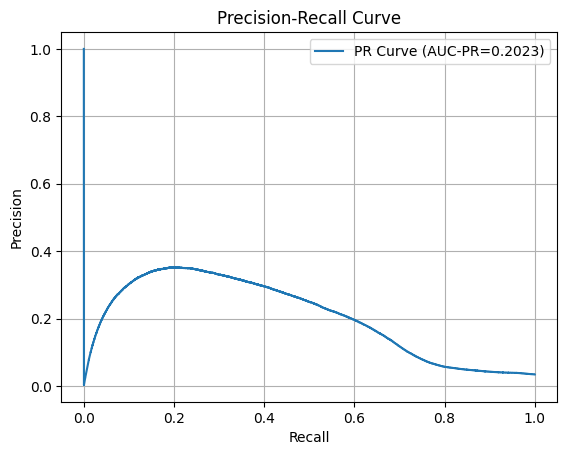

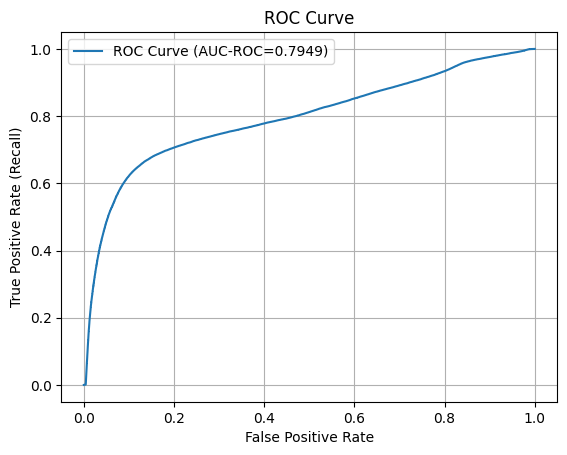

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ----- Precision-Recall Curve -----
precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred)
auc_pr = average_precision_score(y_true, y_pred)

plt.figure()
plt.plot(recall, precision, label=f'PR Curve (AUC-PR={auc_pr:.4f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# ----- ROC Curve -----
fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred)
auc_roc = roc_auc_score(y_true, y_pred)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC-ROC={auc_roc:.4f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


Files in current directory: ['paper_seg_best.keras', '__notebook__.ipynb']
Model loaded successfully from 'paper_seg_best.keras'
Test data loaded from TFRecords: 1689 samples, shape (32, 32, 12)
423/423 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
Predictions generated successfully.


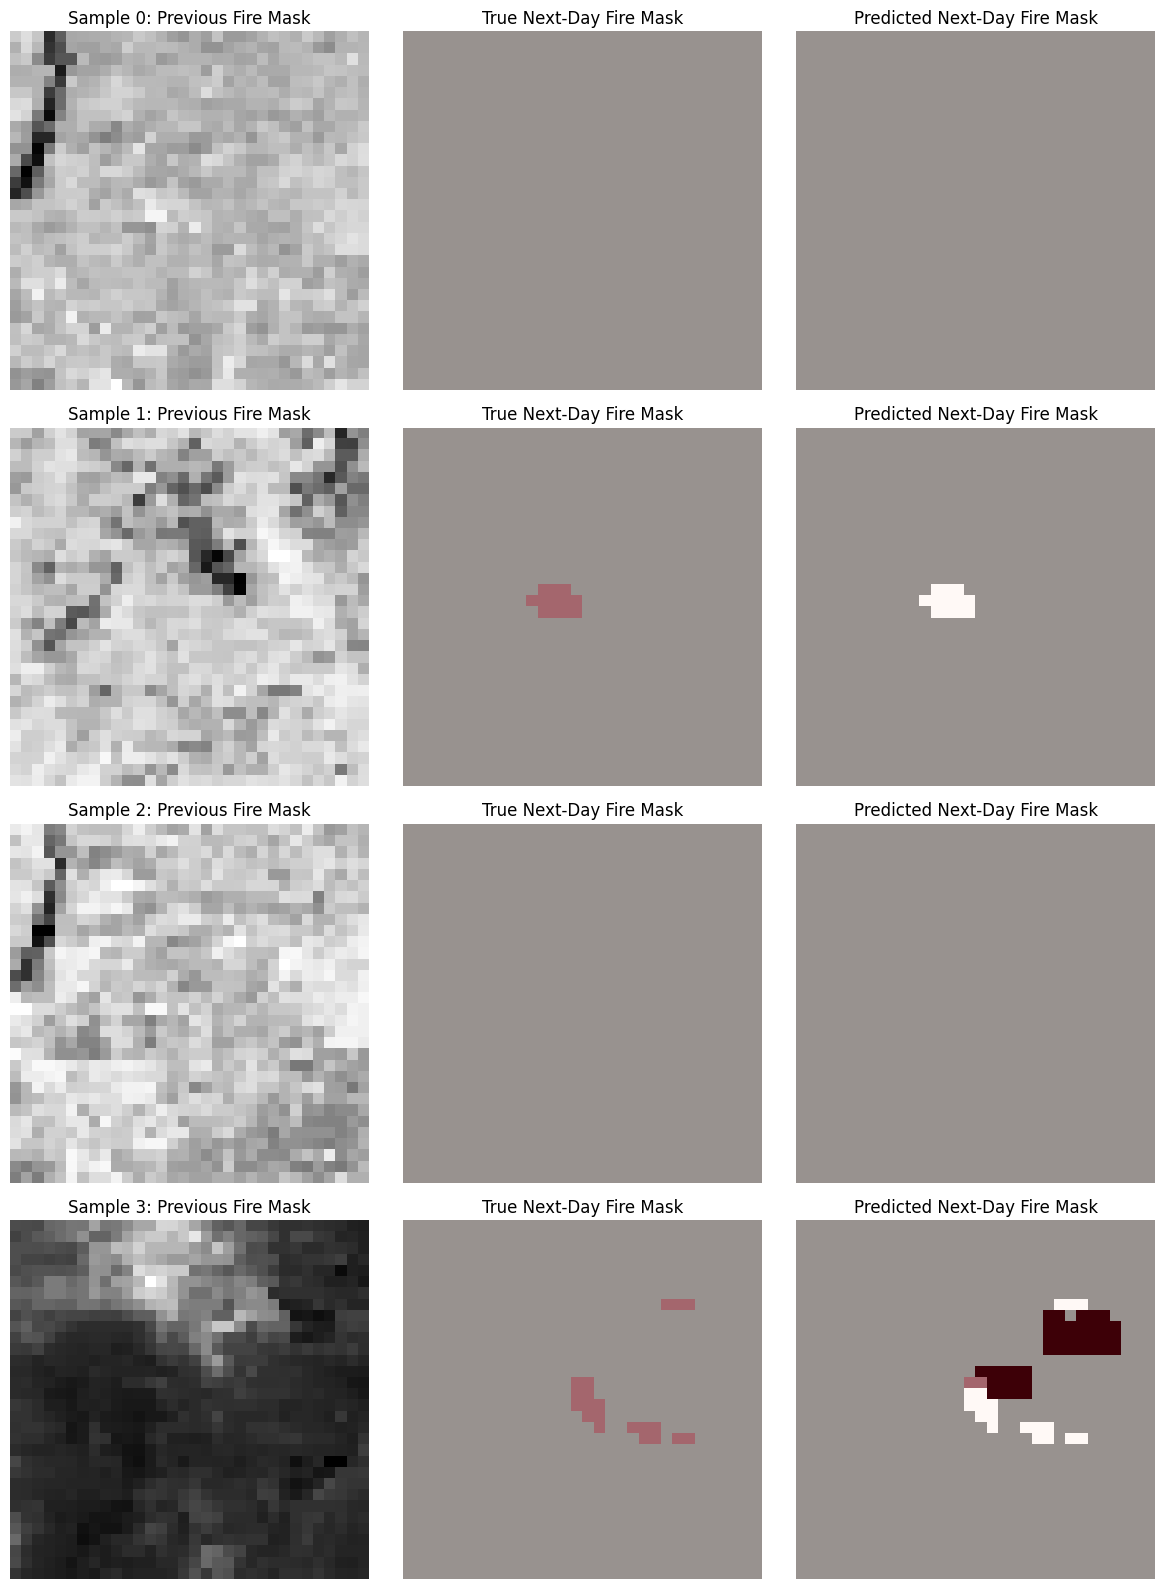

In [13]:
# Wildfire Prediction Visualization (TFRecord Real Data)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os


# STEP 1: Locate and Load Model

print("Files in current directory:", os.listdir())

model_path = None
for fname in ["fire_model.h5", "paper_seg_best.keras"]:
    if os.path.exists(fname):
        model_path = fname
        break

if model_path is None:
    raise FileNotFoundError(" No trained model found. Please place 'fire_model.h5' or 'paper_seg_best.keras' in this directory.")

model = tf.keras.models.load_model(model_path, compile=False)
print(f"Model loaded successfully from '{model_path}'")


# STEP 2: Load Real Test Dataset

# Assuming your test_ds is already built using TFRecords
# (as per your earlier preprocessing pipeline)

# Collect all samples into NumPy arrays
x_test = []
y_test = []

for x_batch, y_batch in test_ds.take(50):   # limit to 50 samples for speed
    x_test.append(x_batch.numpy())
    y_test.append(y_batch.numpy())

x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

print(f"Test data loaded from TFRecords: {x_test.shape[0]} samples, shape {x_test.shape[1:]}")


# STEP 3: Generate Predictions

pred_mask = model.predict(x_test, batch_size=4, verbose=1)
pred_mask = (pred_mask > 0.5).astype(np.uint8)
print("Predictions generated successfully.")


# STEP 4: Visualization Function

def visualize_predictions_grid(indices, input_channel=0):
    """
    Shows multiple wildfire prediction samples in a grid:
    Columns: PrevFireMask | True FireMask | Predicted FireMask
    """
    num_samples = len(indices)
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

    if num_samples == 1:
        axes = np.expand_dims(axes, 0)

    for row, idx in enumerate(indices):
        sample_input = x_test[idx]
        true_mask = y_test[idx].squeeze()
        pred = pred_mask[idx].squeeze()

        #  Previous Day Fire (Input) 
        axes[row, 0].imshow(sample_input[..., 0], cmap="gray")
        axes[row, 0].set_title(f"Sample {idx}: Previous Fire Mask")
        axes[row, 0].axis("off")

        # True Next Day Fire 
        axes[row, 1].imshow(true_mask, cmap="gray")
        axes[row, 1].imshow(true_mask, cmap="Reds", alpha=0.6)
        axes[row, 1].set_title("True Next-Day Fire Mask")
        axes[row, 1].axis("off")

        #  Predicted Next Day Fire 
        axes[row, 2].imshow(true_mask, cmap="gray")
        axes[row, 2].imshow(pred, cmap="Reds", alpha=0.6)
        axes[row, 2].set_title("Predicted Next-Day Fire Mask")
        axes[row, 2].axis("off")

    plt.tight_layout()
    plt.show()


# STEP 5: Visualize Predictions

visualize_predictions_grid(indices=[0, 1, 2, 3], input_channel=0)


In [14]:
import os

DATA_ROOT = "/kaggle/input/next-day-wildfire-spread"

for root, dirs, files in os.walk(DATA_ROOT):
    print("📂 Directory:", root)
    for d in dirs:
        print("   - folder:", d)
    for f in files:
        print("   - file:", f)


📂 Directory: /kaggle/input/next-day-wildfire-spread
   - file: next_day_wildfire_spread_train_14.tfrecord
   - file: next_day_wildfire_spread_train_11.tfrecord
   - file: next_day_wildfire_spread_eval_01.tfrecord
   - file: next_day_wildfire_spread_train_08.tfrecord
   - file: next_day_wildfire_spread_train_13.tfrecord
   - file: next_day_wildfire_spread_train_01.tfrecord
   - file: next_day_wildfire_spread_test_00.tfrecord
   - file: next_day_wildfire_spread_train_10.tfrecord
   - file: next_day_wildfire_spread_train_09.tfrecord
   - file: next_day_wildfire_spread_train_07.tfrecord
   - file: next_day_wildfire_spread_train_12.tfrecord
   - file: next_day_wildfire_spread_train_04.tfrecord
   - file: next_day_wildfire_spread_train_02.tfrecord
   - file: next_day_wildfire_spread_eval_00.tfrecord
   - file: next_day_wildfire_spread_train_03.tfrecord
   - file: next_day_wildfire_spread_train_06.tfrecord
   - file: next_day_wildfire_spread_train_00.tfrecord
   - file: next_day_wildfire_spre

In [15]:
import tensorflow as tf
import os

DATA_ROOT = "/kaggle/input/next-day-wildfire-spread"

# Pick one TFRecord file
sample_record = [os.path.join(DATA_ROOT, f) for f in os.listdir(DATA_ROOT) if f.endswith(".tfrecord")][0]
print("Inspecting:", sample_record)

raw_dataset = tf.data.TFRecordDataset(sample_record)

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    
    print("\n📌 FEATURE KEYS FOUND IN TFRecord:")
    for key in example.features.feature.keys():
        print("   -", key)


Inspecting: /kaggle/input/next-day-wildfire-spread/next_day_wildfire_spread_train_14.tfrecord

📌 FEATURE KEYS FOUND IN TFRecord:
   - NDVI
   - erc
   - th
   - sph
   - tmmn
   - PrevFireMask
   - elevation
   - pr
   - tmmx
   - vs
   - FireMask
   - pdsi
   - population


In [16]:

# Random Forest for Fire Spread Prediction

import os, glob
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.utils.class_weight import compute_class_weight


# 1. Config

DATA_DIR = "/kaggle/input/next-day-wildfire-spread"
IMG_TILE = 64
FEATURE_KEYS = [
    "NDVI","erc","th","sph","tmmn","PrevFireMask",
    "elevation","pr","tmmx","vs","pdsi","population"
]
LABEL_KEY = "FireMask"


# 2. Parse TFRecord

def parse_tfrecord(serialized_example):
    feature_desc = {k: tf.io.VarLenFeature(tf.float32) for k in FEATURE_KEYS + [LABEL_KEY]}
    ex = tf.io.parse_single_example(serialized_example, feature_desc)
    def to_img(name):
        arr = tf.sparse.to_dense(ex[name])
        return tf.reshape(arr, [IMG_TILE, IMG_TILE])
    feats = tf.stack([to_img(k) for k in FEATURE_KEYS], axis=-1)
    lab = to_img(LABEL_KEY)
    lab = tf.expand_dims(lab, axis=-1)
    return feats, lab


# 3. Load examples

def load_examples(file_list, max_samples=20):
    ds = tf.data.TFRecordDataset(file_list).map(parse_tfrecord)
    X, y = [], []
    for i, (x,lab) in enumerate(ds):
        X.append(x.numpy().reshape(-1, len(FEATURE_KEYS)))
        y.append(lab.numpy().reshape(-1))
        if i+1 >= max_samples:
            break
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    y = (y > 0).astype(int)
    return X, y


# 4. Load Data

train_files = sorted(glob.glob(os.path.join(DATA_DIR, "next_day_wildfire_spread_train_*.tfrecord")))
val_files   = sorted(glob.glob(os.path.join(DATA_DIR, "next_day_wildfire_spread_eval_*.tfrecord")))

X_train, y_train = load_examples(train_files, max_samples=50)
X_val, y_val     = load_examples(val_files, max_samples=20)


# 5. Handle Class Imbalance

classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))


# 6. Train Random Forest

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=40,
    min_samples_leaf=5,
    class_weight=class_weights,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)


# 7. Evaluate (AUC-PR)

rf_probs = rf.predict_proba(X_val)[:, 1]
auc_pr = average_precision_score(y_val, rf_probs)


# 8. Feature Importance

importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

print(f"\nRandom Forest Results ")
print(f"AUC-PR (Average Precision): {auc_pr:.6f}\n")
print("Top Feature Importances:")
for idx in sorted_idx:
    print(f"  {FEATURE_KEYS[idx]} -> {importances[idx]:.4f}")



Random Forest Results 
AUC-PR (Average Precision): 0.077089

Top Feature Importances:
  pdsi -> 0.1904
  erc -> 0.1229
  tmmx -> 0.1099
  elevation -> 0.1036
  vs -> 0.0807
  tmmn -> 0.0783
  th -> 0.0760
  sph -> 0.0716
  NDVI -> 0.0519
  pr -> 0.0445
  PrevFireMask -> 0.0401
  population -> 0.0300
